<img src="1.png" width="600">

Давайте для примера возьмем уже известный вам набор данных telecom_churn. Это задача бинарной классификации оттока клиентов. Одним из самых важных признаков в этом датасете является количество звонков в сервисный центр, которые были сделаны клиентом. 

Давайте попробуем визулизировать данные и посмотреть на распределение данного признака:

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
import seaborn as sns
%matplotlib inline

In [2]:
telecom_data = pd.read_csv('telecom_churn.csv')
telecom_data.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


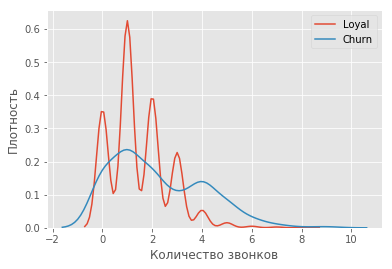

In [3]:
fig = sns.kdeplot(
                telecom_data[telecom_data['Churn'] == False]['Customer service calls'], 
                label = 'Loyal')
fig = sns.kdeplot(
                telecom_data[telecom_data['Churn'] == True]['Customer service calls'], 
                label = 'Churn')        
fig.set(xlabel='Количество звонков', ylabel='Плотность')    
plt.show()

Как вы уже могли заметить, количество звонков в сервисный центр у лояльных клиентов меньше, чем у наших бывших клиентов. Теперь было бы хорошо оценить, сколько в среднем делает звонков каждая из групп. Так как данных в нашем датасете мало, то искать среднее не совсем правильно, лучше применить наши новые знания бутстрэпа. Давайте сгенерируем 1000 новых подвыборок из нашей генеральной совокупности и сделаем интервальную оценку среднего:

In [4]:
import numpy as np

In [5]:
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    
    return samples

def stat_intervals(stat, alpha):
    # функция для интервальной оценки    
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    
    return boundaries

In [6]:
# сохранение в отдельные numpy массивы данных по лояльным и уже бывшим клиентам
loyal_calls = telecom_data[telecom_data['Churn'] == False]['Customer service calls'].values
churn_calls= telecom_data[telecom_data['Churn'] == True]['Customer service calls'].values

# ставим seed для воспроизводимости результатов
np.random.seed(0)

# генерируем выборки с помощью бутстрэра и сразу считаем по каждой из них среднее
loyal_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(loyal_calls, 1000)]
churn_mean_scores = [np.mean(sample) 
                       for sample in get_bootstrap_samples(churn_calls, 1000)]

#  выводим интервальную оценку среднего
print("Service calls from loyal:  mean interval",  stat_intervals(loyal_mean_scores, 0.05))
print("Service calls from churn:  mean interval",  stat_intervals(churn_mean_scores, 0.05))

Service calls from loyal:  mean interval [1.4077193  1.49473684]
Service calls from churn:  mean interval [2.0621118  2.39761905]


В итоге мы получили, что с 95% вероятностью среднее число звонков от лояльных клиентов будет лежать в промежутке между 1.40 и 1.50, в то время как наши бывшие клиенты звонили в среднем от 2.06 до 2.40 раз. Также ещё можно обратить внимание, что интервал для лояльных клиентов уже, что довольно логично, так как они звонят редко (в основном 0, 1 или 2 раза), а недовольные клиенты будут звонить намного чаще, но со временем их терпение закончится, и они поменяют оператора.

---

Код для сравнения решающего дерева, бэггинга и случайного леса для задачи регрессии:

In [7]:
from __future__ import division, print_function
import seaborn as sns
%pylab inline
np.random.seed(42)
figsize(8, 6)

from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [8]:
# Generate data
def f(x):
    x = x.ravel()
    
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2) \
            + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

In [9]:
n_train = 150        
n_test = 1000       
noise = 0.1

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

In [10]:
# One decision tree regressor
dtree = DecisionTreeRegressor().fit(X_train, y_train)
d_predict = dtree.predict(X_test)

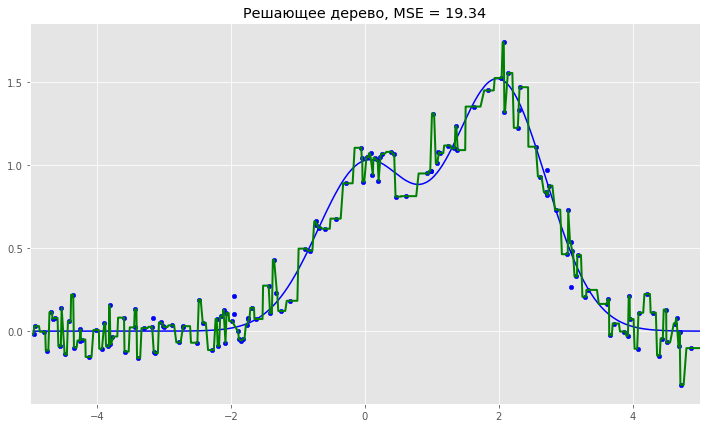

In [11]:
plt.figure(figsize=(12, 7))

plt.xlim([-5, 5])
plt.title("Решающее дерево, MSE = %.2f" % np.sum((y_test - d_predict) ** 2))

plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, d_predict, "g", lw=2)

In [12]:
# Bagging decision tree regressor
bdt = BaggingRegressor(DecisionTreeRegressor()).fit(X_train, y_train)
bdt_predict = bdt.predict(X_test)

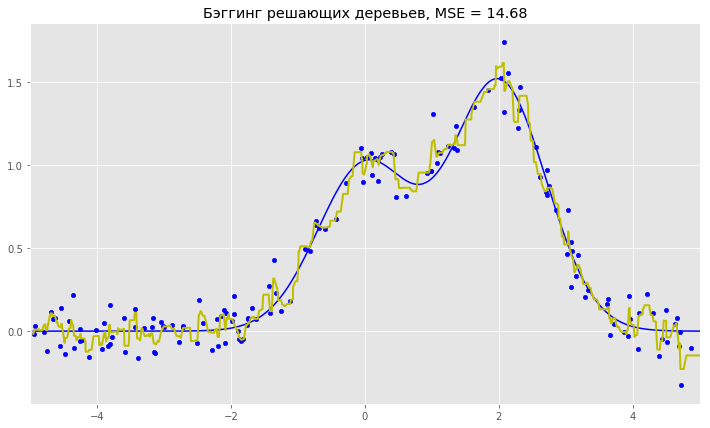

In [13]:
plt.figure(figsize=(12, 7))

plt.xlim([-5, 5])
plt.title("Бэггинг решающих деревьев, MSE = %.2f" % np.sum((y_test - bdt_predict) ** 2))

plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, bdt_predict, "y", lw=2)

In [14]:
# Random Forest
rf = RandomForestRegressor(n_estimators=10).fit(X_train, y_train)
rf_predict = rf.predict(X_test)

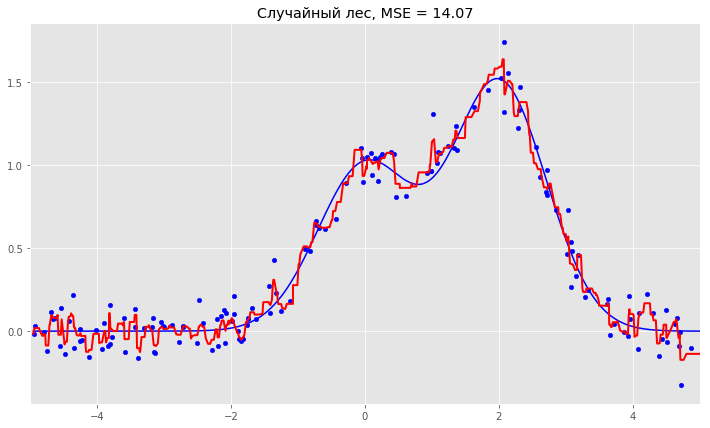

In [15]:
plt.figure(figsize=(12, 7))

plt.xlim([-5, 5])
plt.title("Случайный лес, MSE = %.2f" % np.sum((y_test - rf_predict) ** 2))

plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
plt.plot(X_test, rf_predict, "r", lw=2)

Как мы видим из графиков и значений ошибки MSE, случайный лес из 10 деревьев дает лучший результат, чем одно дерево или бэггинг из 10 деревьев решений. Основное различие случайного леса и бэггинга на деревьях решений заключается в том, что в случайном лесе выбирается случайное подмножество признаков, и лучший признак для разделения узла определяется из подвыборки признаков, в отличие от бэггинга, где все функции рассматриваются для разделения в узле.

Код для сравнения решающего дерева, бэггинга и случайного леса для задачи классификации:

In [16]:
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_circles

import numpy as np
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = 10, 6
%matplotlib inline

In [17]:
np.random.seed(42)
X, y = make_circles(n_samples=500, factor=0.1, noise=0.35, random_state=42)
X_train_circles, X_test_circles, y_train_circles, y_test_circles = train_test_split(X, y, test_size=0.2)

In [18]:
dtree = DecisionTreeClassifier(random_state=42)
dtree.fit(X_train_circles, y_train_circles)

DecisionTreeClassifier(random_state=42)

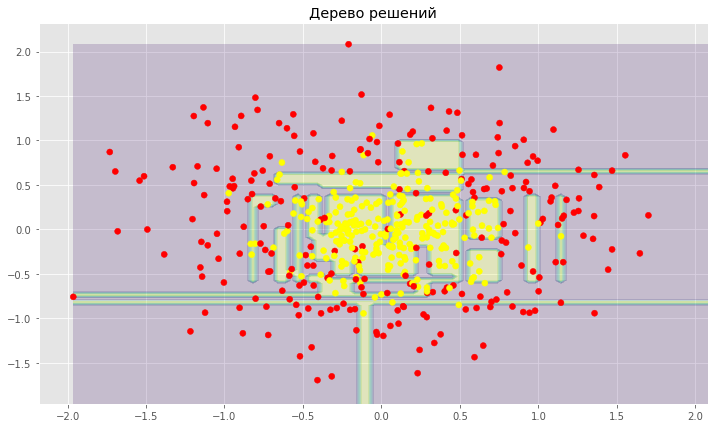

In [19]:
x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)

y_hat = dtree.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)

plt.figure(figsize=(12, 7))
plt.title("Дерево решений")

plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.show()

In [20]:
b_dtree = BaggingClassifier(DecisionTreeClassifier(),n_estimators=300, random_state=42)
b_dtree.fit(X_train_circles, y_train_circles)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=300,
                  random_state=42)

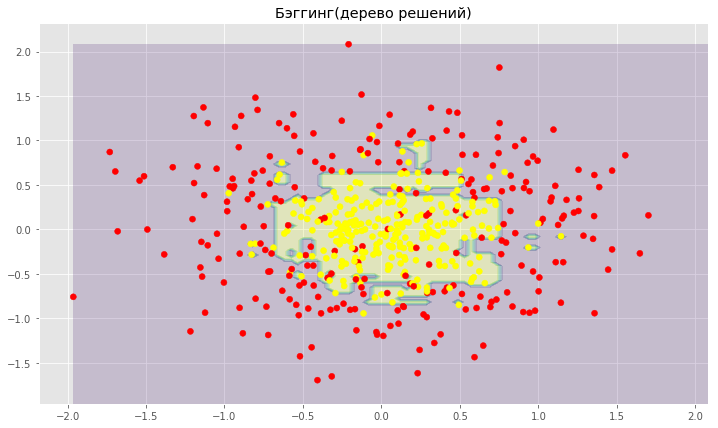

In [21]:
x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)

y_hat = b_dtree.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)

plt.figure(figsize=(12, 7))
plt.title("Бэггинг(дерево решений)")

plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.show()

In [22]:
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train_circles, y_train_circles)

RandomForestClassifier(n_estimators=300, random_state=42)

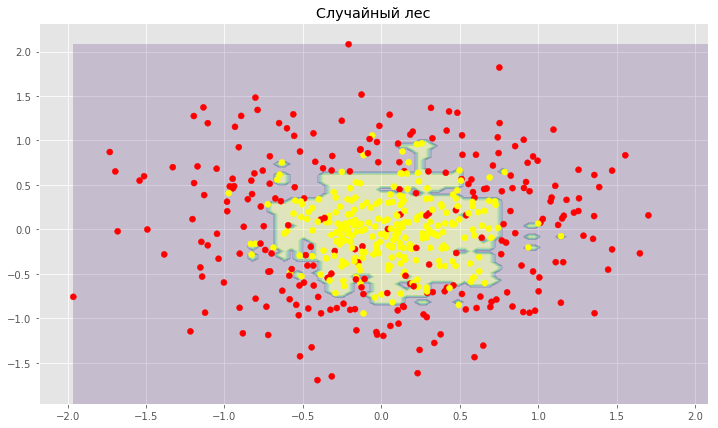

In [23]:
x_range = np.linspace(X.min(), X.max(), 100)
xx1, xx2 = np.meshgrid(x_range, x_range)

y_hat = rf.predict(np.c_[xx1.ravel(), xx2.ravel()])
y_hat = y_hat.reshape(xx1.shape)

plt.figure(figsize=(12, 7))
plt.title("Случайный лес")

plt.contourf(xx1, xx2, y_hat, alpha=0.2)
plt.scatter(X[:,0], X[:,1], c=y, cmap='autumn')
plt.show()

На рисунках выше видно, что разделяющая граница дерева решений очень «рваная» и на ней много острых углов, что говорит о переобучении и слабой обобщающей способности. В то время как у бэггинга и случайного леса граница достаточно сглаженная и практически нет признаков переобучения.

---

Рассмотрим применение случайного леса в реальной задаче.


Для этого будем использовать пример с задачей оттока клиентов. Это задача классификации, поэтому будем использовать метрику accuracy для оценки качества модели. Для начала построим самый простой классификатор, который будет нашим бейслайном. Возьмем только числовые признаки для упрощения:

In [24]:
import pandas as pd
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

In [25]:
df = pd.read_csv("telecom_churn.csv")
df.head()

,State,Account length,Area code,International plan,Voice mail plan,Number vmail messages,Total day minutes,Total day calls,Total day charge,Total eve minutes,Total eve calls,Total eve charge,Total night minutes,Total night calls,Total night charge,Total intl minutes,Total intl calls,Total intl charge,Customer service calls,Churn
0,KS,128,415,No,Yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,No,Yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,No,No,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,Yes,No,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,Yes,No,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [26]:
cols = []
for i in df.columns:
    if (df[i].dtype == "float64") or (df[i].dtype == 'int64'):
        cols.append(i)

In [27]:
X, y = df[cols].copy(), np.asarray(df["Churn"],dtype='int8')

In [28]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [29]:
rfc = RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=True)

In [30]:
results = cross_val_score(rfc, X, y, cv=skf)

In [31]:
print("CV accuracy score: {:.2f}%".format(results.mean()*100))

CV accuracy score: 92.50%


Теперь попробуем улучшить этот результат и посмотреть, как ведут себя кривые валидации при изменении основных параметров:

In [32]:
# Инициализируем валидацию
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
trees_grid = [5, 10, 15, 20, 30, 50, 75, 100]

In [33]:
# Обучаем на тренировочном датасете
for ntrees in trees_grid:
    rfc = RandomForestClassifier(n_estimators=ntrees, random_state=42, n_jobs=-1, oob_score=True)
    
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        rfc.fit(X_train, y_train)
        
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
        
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

In [34]:
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} trees".format(
                                                            max(test_acc.mean(axis=1))*100, 
                                                            trees_grid[np.argmax(test_acc.mean(axis=1))]
                                                        ))

Best accuracy on CV is 92.50% with 100 trees


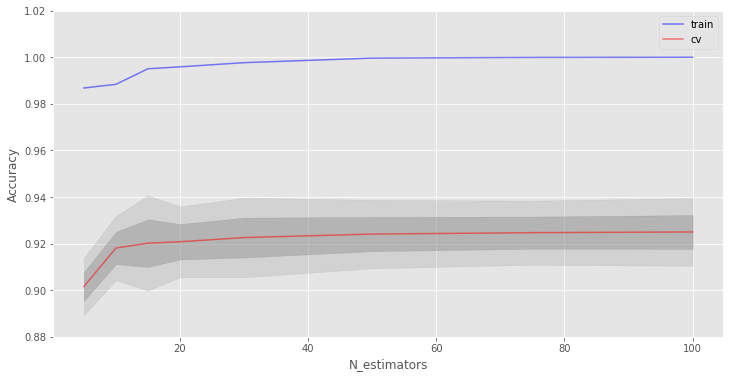

In [35]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("N_estimators")

ax.plot(trees_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(trees_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(trees_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(trees_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')

Как видно, при достижении определенного числа деревьев наша доля верных ответов на тесте выходит на асимптоту.
На рисунке также видно, что на тренировочной выборке мы смогли достичь 100% точности, это говорит нам о переобучении нашей модели. Чтобы избежать переобучения, мы должны добавить параметры регуляризации в модель (зафиксируем к-во деревьев 100):

In [36]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_depth_grid = [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

In [37]:
# Обучаем на тренировочном датасете
for max_depth in max_depth_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True, max_depth=max_depth)
    
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
        
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

In [38]:
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_depth".format(
                                                                max(test_acc.mean(axis=1))*100, 
                                                                max_depth_grid[np.argmax(test_acc.mean(axis=1))]
                                                            ))

Best accuracy on CV is 92.44% with 24 max_depth


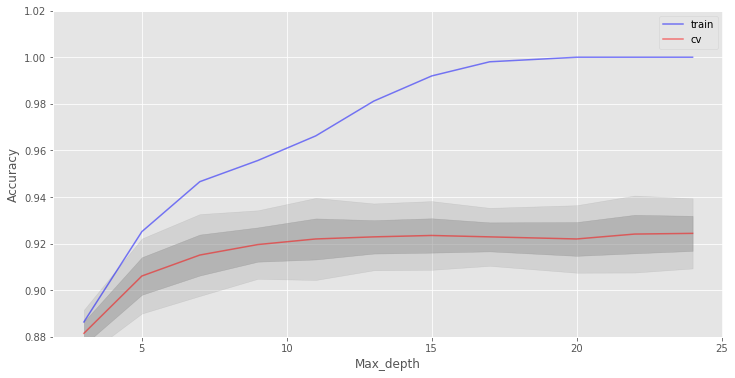

In [39]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_depth")

ax.plot(max_depth_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_depth_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_depth_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')

Параметр max_depth хорошо справляется с регуляризацией модели, и мы уже не так сильно переобучаемся.

In [40]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
min_samples_leaf_grid = [1, 3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24]

In [41]:
# Обучаем на тренировочном датасете
for min_samples_leaf in min_samples_leaf_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                 oob_score=True, min_samples_leaf=min_samples_leaf)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
        
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

In [42]:
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} min_samples_leaf".format(
                                                                max(test_acc.mean(axis=1))*100, 
                                                                min_samples_leaf_grid[np.argmax(test_acc.mean(axis=1))]
                                                            ))

Best accuracy on CV is 92.50% with 1 min_samples_leaf


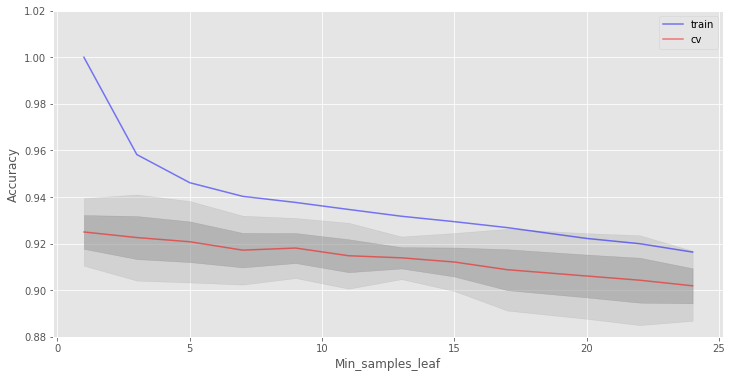

In [43]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Min_samples_leaf")

ax.plot(min_samples_leaf_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(min_samples_leaf_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(min_samples_leaf_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')

В данном случае мы не выигрываем в точности на валидации, но зато можем значительно уменьшить переобучение до 2% при сохранении точности около 92%.

In [44]:
# Создаем списки для сохранения точности на тренировочном и тестовом датасете
train_acc = []
test_acc = []
temp_train_acc = []
temp_test_acc = []
max_features_grid = [2, 4, 6, 8, 10, 12, 14, 16]

In [45]:
# Обучаем на тренировочном датасете
for max_features in max_features_grid:
    rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, 
                                 oob_score=True, max_features=max_features)
    temp_train_acc = []
    temp_test_acc = []
    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        rfc.fit(X_train, y_train)
        
        temp_train_acc.append(rfc.score(X_train, y_train))
        temp_test_acc.append(rfc.score(X_test, y_test))
        
    train_acc.append(temp_train_acc)
    test_acc.append(temp_test_acc)

In [46]:
train_acc, test_acc = np.asarray(train_acc), np.asarray(test_acc)
print("Best accuracy on CV is {:.2f}% with {} max_features".format(
                                                                    max(test_acc.mean(axis=1))*100, 
                                                                    max_features_grid[np.argmax(test_acc.mean(axis=1))]
                                                                ))

Best accuracy on CV is 92.50% with 4 max_features


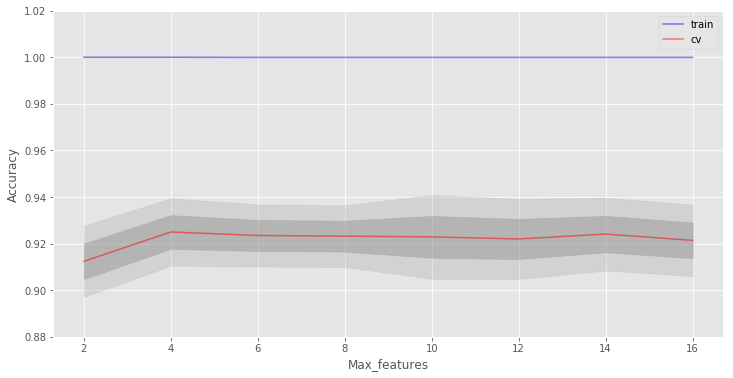

In [47]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set_ylim([0.88,1.02])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Max_features")

ax.plot(max_features_grid, train_acc.mean(axis=1), alpha=0.5, color='blue', label='train')
ax.plot(max_features_grid, test_acc.mean(axis=1), alpha=0.5, color='red', label='cv')
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - test_acc.std(axis=1), test_acc.mean(axis=1) + test_acc.std(axis=1), color='#888888', alpha=0.4)
ax.fill_between(max_features_grid, test_acc.mean(axis=1) - 2*test_acc.std(axis=1), test_acc.mean(axis=1) + 2*test_acc.std(axis=1), color='#888888', alpha=0.2)
ax.legend(loc='best')

В нашем случае оптимальное число признаков — 10, именно с таким значением достигается наилучший результат.

Мы рассмотрели, как ведут себя кривые валидации в зависимости от изменения основных параметров. Давайте теперь с помощью GridSearchCV найдем оптимальные параметры для нашего примера:

In [48]:
# Сделаем инициализацию параметров, по которым хотим сделать полный перебор
parameters = {'max_features': [4, 7, 10, 13], 
              'min_samples_leaf': [1, 3, 5, 7], 
              'max_depth': [5,10,15,20]}

In [49]:
rfc = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, oob_score=True)
gcv = GridSearchCV(rfc, parameters, n_jobs=-1, cv=skf, verbose=1)
gcv.fit(X, y)

Fitting 5 folds for each of 64 candidates, totalling 320 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 320 out of 320 | elapsed:  2.1min finished


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=RandomForestClassifier(n_jobs=-1, oob_score=True,
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, 15, 20],
                         'max_features': [4, 7, 10, 13],
                         'min_samples_leaf': [1, 3, 5, 7]},
             verbose=1)

In [50]:
gcv.best_params_

{'max_depth': 20, 'max_features': 10, 'min_samples_leaf': 3}

---
---
---

Рассмотрим результаты анкетирования посетителей хостелов с сайтов Booking.com и TripAdvisor.com. Признаки — средние оценки по разным факторам (перечислены ниже) — персонал, состояние комнат и т.д. Целевой признак — рейтинг хостела на сайте.

Оценим важности признаков:

In [51]:
from __future__ import division, print_function

import pandas as pd
import numpy as np
from sklearn.ensemble.forest import RandomForestRegressor

%pylab inline
import seaborn as sns
# russian headres
from matplotlib import rc
font = {'family': 'Verdana',
        'weight': 'normal'}
rc('font', **font)

import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [52]:
hostel_data = pd.read_csv("hostel_factors.csv")
hostel_data.head()

,hostel,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,rating
0,hostel1,0.675000,0.100000,0.300000,0.875000,0.250000,0.425000,0.350000,0.725000,0.400000,0.275000,9.0
1,hostel2,0.500000,0.000000,0.058824,0.573529,0.117647,0.382353,0.000000,0.161765,0.308824,0.000000,8.3
2,hostel3,0.520833,0.041667,0.020833,0.666667,0.229167,0.437500,0.270833,0.250000,0.395833,0.270833,8.6
3,hostel4,0.692308,0.038462,0.038462,0.346154,0.076923,0.307692,0.500000,0.115385,0.153846,0.269231,7.6
4,hostel5,0.620690,0.000000,0.000000,0.517241,0.172414,0.344828,0.172414,0.379310,0.103448,0.310345,8.7


In [53]:
features = {"f1":u"Персонал",
            "f2":u"Бронирование хостела ",
            "f3":u"Заезд в хостел и выезд из хостела",
            "f4":u"Состояние комнаты",
            "f5":u"Состояние общей кухни",
            "f6":u"Состояние общего пространства",
            "f7":u"Дополнительные услуги",
            "f8":u"Общие условия и удобства",
            "f9":u"Цена/качество",
            "f10":u"ССЦ"}

In [54]:
forest = RandomForestRegressor(n_estimators=1000, max_features=10, random_state=0)
forest.fit(hostel_data.drop(['hostel', 'rating'], axis=1), 
           hostel_data['rating'])

importances = forest.feature_importances_
importances

array([0.18315025, 0.05389933, 0.0618808 , 0.03910477, 0.07477573,
       0.12818775, 0.1168194 , 0.08872999, 0.14770441, 0.10574756])

Feature ranking:
1. Персонал 0.183150 
2. Цена/качество 0.147704 
3. Состояние общего пространства 0.128188 
4. Дополнительные услуги 0.116819 
5. ССЦ 0.105748 
6. Общие условия и удобства 0.088730 
7. Состояние общей кухни 0.074776 
8. Заезд в хостел и выезд из хостела 0.061881 
9. Бронирование хостела  0.053899 
10. Состояние комнаты 0.039105 


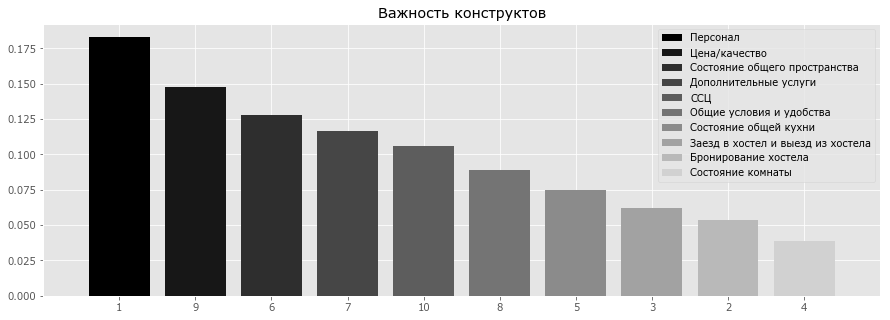

In [55]:
indices = np.argsort(importances)[::-1]
# Plot the feature importancies of the forest
num_to_plot = 10
feature_indices = [ind+1 for ind in indices[:num_to_plot]]

# Print the feature ranking
print("Feature ranking:")

for f in range(num_to_plot):
    print("%d. %s %f " % (f + 1, 
                            features["f"+str(feature_indices[f])], 
                            importances[indices[f]]
                        ))
    
plt.figure(figsize=(15,5))
plt.title(u"Важность конструктов")
plt.xlim([-1, num_to_plot])
ticks = plt.xticks(range(num_to_plot), feature_indices)

bars = plt.bar(range(num_to_plot), 
               importances[indices[:num_to_plot]],
               color=([str(i/float(num_to_plot+1)) 
               for i in range(num_to_plot)]),
               align="center")
plt.legend(bars, [u''.join(features["f"+str(i)]) 
                  for i in feature_indices]);

На рисунке выше видно, что люди больше всего обращают внимание на персонал и соотношение цена/качество и на основе впечатления от данных вещей пишут свои отзывы. Но разница между этими признаками и менее влиятельными признаками не очень значительная, и выкидывание какого-то признака приведет к уменьшению точности нашей модели. Но даже на основе нашего анализа мы можем дать рекомендации отелям в первую очередь лучше готовить персонал и/или улучшить качество до заявленной цены.